In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, AveragePooling2D
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/512/train/'
test_dir = 'data/512/test/'
test_dir_whithout_aug = "data/512/test-without-aug/"

extracted_features_dir = "extracted_features/"
model_name = "DenseNet201_Pooling_512_Adam3_50_epoch"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir_whithout_aug):
    print (root, len(files))

data/512/train/ 0
data/512/train/Benign 1152
data/512/train/InSitu 1152
data/512/train/Invasive 1152
data/512/train/Normal 1152
******************************
data/512/test/ 0
data/512/test/Benign 448
data/512/test/InSitu 448
data/512/test/Invasive 448
data/512/test/Normal 448
******************************
data/512/test-without-aug/ 0
data/512/test-without-aug/Benign 28
data/512/test-without-aug/InSitu 28
data/512/test-without-aug/Invasive 28
data/512/test-without-aug/Normal 28


In [5]:
output_classes = 4
batch_size = 32
img_height, img_width = 512, 384
input_shape = (img_height, img_width, 3)
epochs = 50

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)

train samples: 4608
test samples: 1792


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_generator_without_aug = test_datagen.flow_from_directory(
    test_dir_whithout_aug,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3456 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 1792 images belonging to 4 classes.
Found 112 images belonging to 4 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)

nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

print("nb_test_samples:", nb_test_without_aug_samples)
print("predict_size_test:", predict_size_test_without_aug)

print("\n num_classes:", num_classes)

nb_train_samples: 3456
nb_validation_samples: 1152

predict_size_train: 108
predict_size_validation: 36
nb_test_samples: 112
predict_size_test: 4

 num_classes: 4


In [8]:
nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

nb_test_samples: 1792
predict_size_test: 56


In [9]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_DenseNet201_pooling_512.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_DenseNet201_pooling_512.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_DenseNet201_pooling_512.npy')
test_data_without_aug = np.load(extracted_features_dir+'bottleneck_features_test_without_aug_DenseNet201_pooling_512.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)


test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

test_labels_without_aug = test_generator_without_aug.classes
test_labels_without_aug = to_categorical(test_labels_without_aug, num_classes=num_classes)

In [10]:
dropout_rate = 0.6

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

adam_opt3=Adam(lr = 0.001, beta_1=0.8, beta_2=0.9, amsgrad=True, epsilon=None, decay=0.0)

model.compile(optimizer=adam_opt3, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 3456 samples, validate on 1152 samples
Epoch 1/50
 - 6s - loss: 4.2507 - acc: 0.5067 - val_loss: 0.6473 - val_acc: 0.7856
Epoch 2/50
 - 2s - loss: 0.6458 - acc: 0.7448 - val_loss: 0.3049 - val_acc: 0.9184
Epoch 3/50
 - 2s - loss: 0.3973 - acc: 0.8559 - val_loss: 0.1902 - val_acc: 0.9470
Epoch 4/50
 - 2s - loss: 0.2701 - acc: 0.8958 - val_loss: 0.1299 - val_acc: 0.9609
Epoch 5/50
 - 2s - loss: 0.1908 - acc: 0.9308 - val_loss: 0.1058 - val_acc: 0.9627
Epoch 6/50
 - 2s - loss: 0.1652 - acc: 0.9439 - val_loss: 0.0762 - val_acc: 0.9809
Epoch 7/50
 - 2s - loss: 0.1290 - acc: 0.9575 - val_loss: 0.0717 - val_acc: 0.9774
Epoch 8/50
 - 2s - loss: 0.0985 - acc: 0.9667 - val_loss: 0.0466 - val_acc: 0.9878
Epoch 9/50
 - 2s - loss: 0.0955 - acc: 0.9670 - val_loss: 0.0414 - val_acc: 0.9887
Epoch 10/50
 - 2s - loss: 0.0826 - acc: 0.9751 - val_loss: 0.0381 - val_acc: 0.9896
Epoch 11/50
 - 2s - loss: 0.0760 - acc: 0.9742 - val_loss: 0.0357 - val_acc: 0.9905
Epoch 12/50
 - 2s - loss: 0.0686 - ac

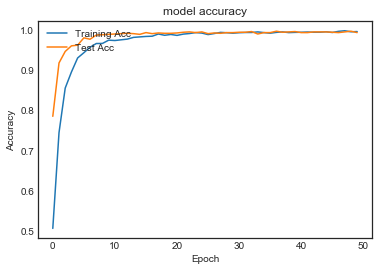

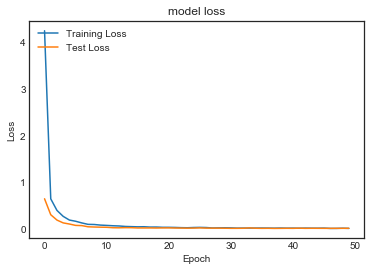

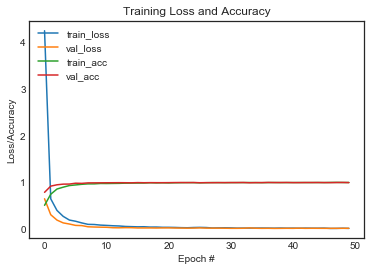

In [11]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [12]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 0s 272us/step
Validation Accuracy: 99.3924%
Validation Loss: 0.014530531424851587


# Test augmented

In [13]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8337053571428571


Confusion Matrix
[[414  17  17   0]
 [ 72 356  16   4]
 [ 26  46 376   0]
 [ 61  31   8 348]]


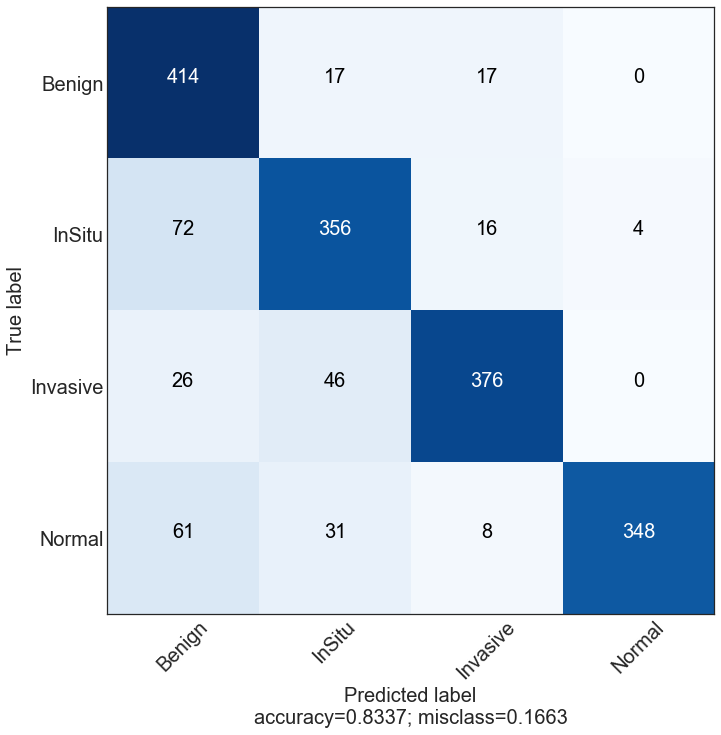

In [14]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[414  17  17   0]
 [ 72 356  16   4]
 [ 26  46 376   0]
 [ 61  31   8 348]]
              precision    recall  f1-score   support

    Invasive       0.72      0.92      0.81       448
      InSitu       0.79      0.79      0.79       448
      Benign       0.90      0.84      0.87       448
      Normal       0.99      0.78      0.87       448

   micro avg       0.83      0.83      0.83      1792
   macro avg       0.85      0.83      0.84      1792
weighted avg       0.85      0.83      0.84      1792



In [16]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  85.18518518518519
Specificity :  95.44235924932975


____
# test without augmentation

In [17]:
preds = model.predict(test_data_without_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_without_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8660714285714286


Confusion Matrix
[[27  1  0  0]
 [ 4 23  1  0]
 [ 2  3 23  0]
 [ 3  1  0 24]]


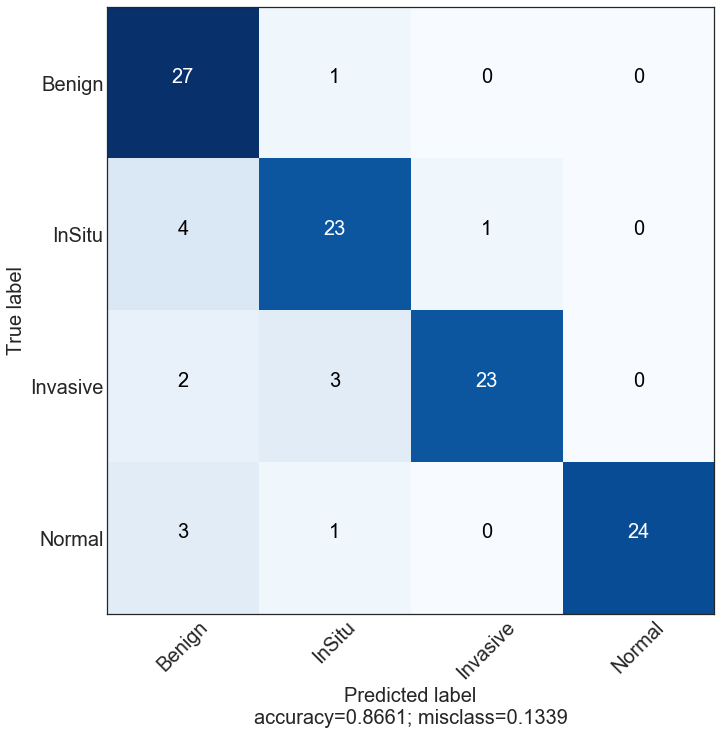

In [18]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator_without_aug.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator_without_aug.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[27  1  0  0]
 [ 4 23  1  0]
 [ 2  3 23  0]
 [ 3  1  0 24]]
              precision    recall  f1-score   support

    Invasive       0.75      0.96      0.84        28
      InSitu       0.82      0.82      0.82        28
      Benign       0.96      0.82      0.88        28
      Normal       1.00      0.86      0.92        28

   micro avg       0.87      0.87      0.87       112
   macro avg       0.88      0.87      0.87       112
weighted avg       0.88      0.87      0.87       112



In [20]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  87.09677419354838
Specificity :  95.83333333333334
